# Boundary conditions and numerical stability solutions

## Insulating boundary

To implement an insulating boundary on the left, i.e. $dT/dx=0$ at $x=0$, we need to look at the update equation for the leftmost grid point at $i=1$:

$$-\alpha T^{n+1}_0 + (1+2\alpha) T^{n+1}_1 -\alpha T^{n+1}_2 = T^n_1.$$

The temperature $T_0$ is off the grid, so we need to use the boundary condition to determine its value. This is easy for the insulating boundary since $dT/dx=0$ means that $T_0 = T_1$. Therefore, the update equation for $i=1$ is

$$-\alpha T^{n+1}_1 + (1+2\alpha) T^{n+1}_1 -\alpha T^{n+1}_2 = T^n_1$$

$$\Rightarrow (1+\alpha) T^{n+1}_1 -\alpha T^{n+1}_2 = T^n_1.$$

This means that we need to modify the top left of the matrix so that the diagonal element is $1+\alpha$ rather than $1+2\alpha$.

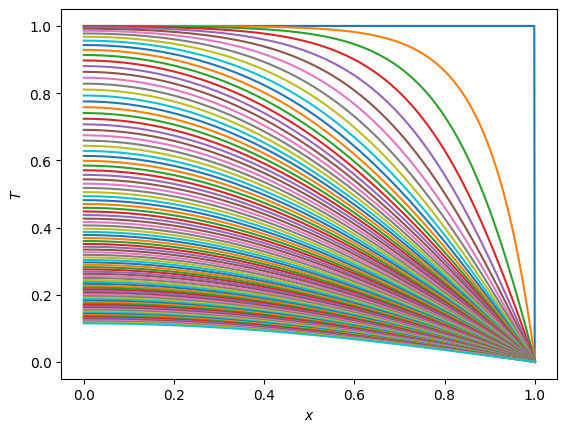

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

n = 1001
x = np.linspace(0, 1, n)

# Initial profile has T=1 everywhere except T=0 at the outer boundary
T = np.ones(n)
T[-1] = 0.0

plt.plot(x, T)
plt.xlabel(r'$x$')
plt.ylabel(r'$T$')

dx = x[1]-x[0]
dt = 1e-2
alpha = dt/dx**2
nsteps = 100

# Calculate the matrix A in banded form
b = (1 + 2*alpha) * np.ones(n)
b[0] = 1 + alpha       #<=========  New line to implement insulating boundary
a = -alpha * np.ones(n)
c = -alpha * np.ones(n)
c[-1] = 0.0
a[0] = 0.0
AA = np.row_stack((a,b,c))

# and the b vector (boundaries)
bvec = np.zeros(n)
#bvec[0] = 1    <===== Also we no longer need this since we are not fixing the value at the boundary

for i in range(1,nsteps):
    T = scipy.linalg.solve_banded((1,1), AA, T + alpha*bvec)
    plt.plot(x, T)
plt.show()

## Numerical stability

First we'll do the von Neumann stability analysis for the implicit Euler update

$$T^{n+1}_j = T^n_j + \alpha (T^{n+1}_{j-1} -2 T^{n+1}_j + T^{n+1}_{j+1}).$$

Plug in

$$T^n_j = \xi^n e^{ikx} = \xi^n e^{ik(j\Delta x)}$$

which gives

$$\xi^{n+1} e^{ik(j\Delta x)} = \xi^n e^{ik(j\Delta x)} + \alpha \xi^{n+1}\left(e^{ik((j-1)\Delta x)} -2 e^{ik(j\Delta x)} + e^{ik((j+1)\Delta x)}\right)$$

$$\xi = 1 + \alpha \xi \left( -2 + e^{-ik\Delta x} + e^{ik\Delta x}\right)$$

$$\xi = 1 + 2\alpha \xi \left( -1 + \cos(k\Delta x)\right)$$

$$\xi = {1\over  1 + 2\alpha \left( 1 - \cos(k\Delta x)\right) } = {1\over  1 + 4\alpha \sin^2\left(k\Delta x/2\right) }.$$

So we can see that $|\xi|\leq 1$ for any choice of $\alpha$, this method is always stable.

Next, let's implement the explicit update and try an unstable timestep:

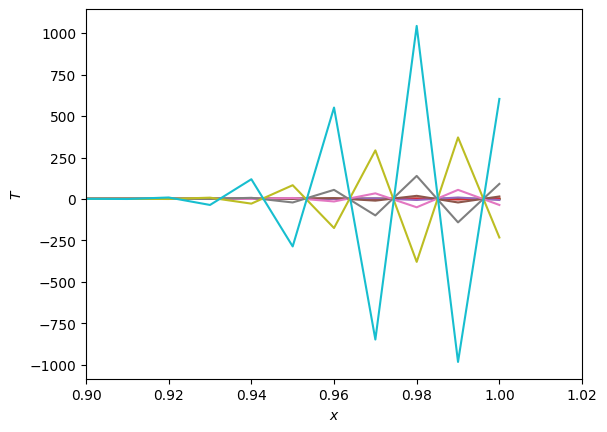

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

n = 101
x = np.linspace(0, 1, n)

# Initial profile has T=1 everywhere except T=0 at the outer boundary
T = np.ones(n)
T[-1] = 0.0

plt.plot(x, T)
plt.xlabel(r'$x$')
plt.ylabel(r'$T$')
plt.xlim((0.9,1.0))

dx = x[1]-x[0]
alpha = 1.0
dt = alpha * dx**2
nsteps = 10

# Calculate the matrix A for the explicit update
b = (1 - 2*alpha) * np.ones(n)
b[0] = (1 - alpha)
a = alpha * np.ones(n-1)
AA = np.diag(b) + np.diag(a,k=-1) + np.diag(a,k=+1)

for i in range(1,nsteps):
    T = AA@T
    plt.plot(x, T)
plt.show()

If you run this with $\alpha\leq 1/2$ it will be stable and give the same solution as before, although a lot more slowly. Above we've taken $\alpha=1$ and zoomed in on the right hand part of the grid. We see that the unstable mode is such that alternate grid points move in opposite directions: the wavelength is twice the grid spacing as predicted by our stability analysis.